# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
nltk.download(['punkt', 'wordnet','stopwords'])

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64


Text(0.5,1,'distribution of individual interactions with the articles')

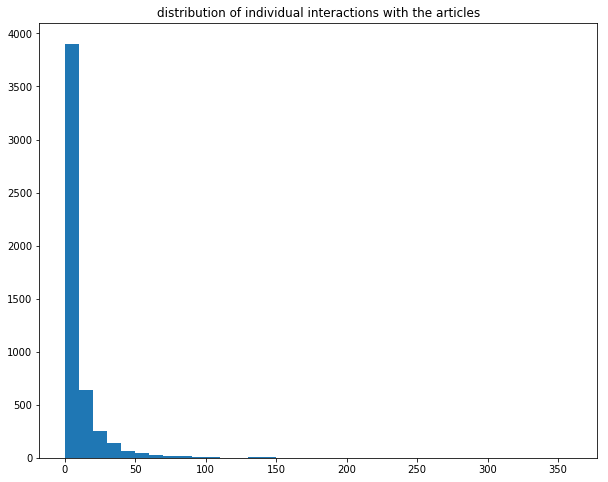

In [3]:
interaction_counts = df.groupby("email")["article_id"].count()
print (interaction_counts.describe())

bins = range(0, 370, 10)
plt.figure(figsize=(10,8))
plt.hist(interaction_counts, bins = bins)
plt.title('distribution of individual interactions with the articles')

Text(0.5,1,'distribution of individual interactions with the articles - In a Range from 0 to 50')

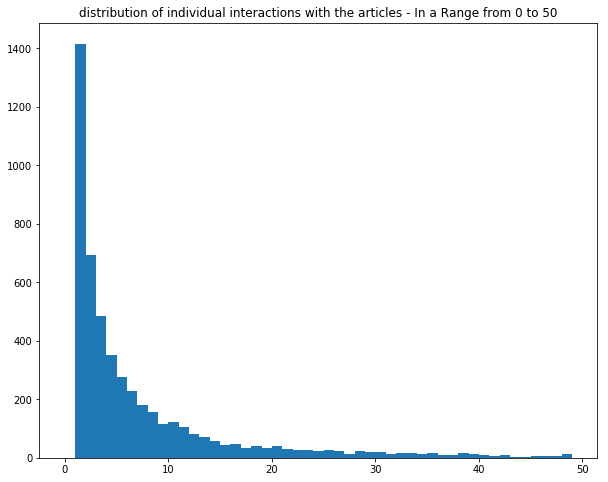

In [4]:
bins = range(0, 50, 1)
plt.figure(figsize=(10,8))
plt.hist(interaction_counts, bins = bins)
plt.title('distribution of individual interactions with the articles - In a Range from 0 to 50')

In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = interaction_counts.describe()['50%'] # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = interaction_counts.describe()['max'] # The maximum number of user-article interactions by any 1 user is ______.
print ("50% of individuals interact with {} number of articles or fewer. \nThe maximum number of user-article interactions by any 1 user is {}.".format(median_val, max_views_by_user))


50% of individuals interact with 3.0 number of articles or fewer. 
The maximum number of user-article interactions by any 1 user is 364.0.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles
sum(df_content['article_id'].value_counts() > 1)

5

In [7]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates("article_id", keep="first")
df_content = df_content.reset_index(drop=True)
print (df_content.shape)
df_content.tail()

(1051, 5)


,doc_body,doc_description,doc_full_name,doc_status,article_id
1046,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1047,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1048,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1049,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049
1050,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
unique_articles = len(df.article_id.unique()) # The number of unique articles that have at least one interaction
total_articles = df_content.shape[0] # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

print ("a. The number of unique articles that have an interaction with a user: {} \nb. The number of unique articles in the dataset (whether they have any interactions or not): {} \nc. The number of unique users in the dataset. (excluding null values): {} \nd. The number of user-article interactions in the dataset: {}".format(unique_articles, total_articles, unique_users, user_article_interactions))

a. The number of unique articles that have an interaction with a user: 714 
b. The number of unique articles in the dataset (whether they have any interactions or not): 1051 
c. The number of unique users in the dataset. (excluding null values): 5148 
d. The number of user-article interactions in the dataset: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [9]:
article_grp = df.groupby(['article_id']).count().sort_values(by='email', ascending = False)
article_grp.head()

,title,email
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627


In [10]:
most_viewed_article_id = str(article_grp.index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = article_grp.iloc[0, 0] # The most viewed article in the dataset was viewed how many times?
print ("The most viewed article in the dataset is the article with article_id of {}. It has been viewed for {} times.".format(most_viewed_article_id, max_views))

The most viewed article in the dataset is the article with article_id of 1429.0. It has been viewed for 937 times.


In [11]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [12]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [13]:
def get_top_articles(n, df = df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    article_ids = get_top_article_ids(n, df = df)
    article_id_title = df[['article_id', 'title']].drop_duplicates("article_id", keep="first")
    article_id_title = article_id_title.reset_index(drop=True)
    top_articles = article_id_title[article_id_title['article_id'].isin(article_ids)]['title']
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Your code here
    article_grp = df.groupby(['article_id'])['user_id'].count().sort_values(ascending = False)
    top_articles = [str(x) for x in article_grp.index[:n]]
 
    return top_articles # Return the top article ids

In [14]:
print(get_top_articles(10))
print(get_top_article_ids(10))

1          healthcare python streaming application demo
2            use deep learning for image classification
11             apache spark lab, part 1: basic concepts
19    predicting churn with the spss random tree alg...
21              analyze energy consumption in buildings
24                       visualize car data with brunel
27    use xgboost, scikit-learn & ibm watson machine...
36    gosales transactions for logistic regression m...
42          insights from new york car accident reports
73    finding optimal locations of new store using d...
Name: title, dtype: object
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [15]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [16]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id'])['title'].apply(lambda x: 1).unstack(level= -1, fill_value = 0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [17]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [18]:
# Get the similarity matrix for all users
def get_similarity_mat(user_item = user_item):
    sim_mat = np.dot(user_item, user_item.T)
    user_ids = user_item.index
    sim_mat = pd.DataFrame(sim_mat, index = user_ids, columns = user_ids)
    return sim_mat

In [19]:
sim_mat = get_similarity_mat(user_item)

def find_similar_users(user_id, user_item = user_item, similarity_mat = sim_mat):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    similarity_mat - an NxN matrix of similarity of each user pair in the dataset
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    # remove the own user's id
    # sort by similarity
    sorted_usr_sim = sim_mat.loc[user_id, sim_mat.columns != user_id].sort_values(ascending = False)
    
    # create list of just the ids
    most_similar_users = sorted_usr_sim.index
        
    return most_similar_users # return a list of the users in order from most to least similar
        

In [20]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: Int64Index([3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697], dtype='int64', name='user_id')
The 5 most similar users to user 3933 are: Int64Index([1, 3782, 23, 203, 4459], dtype='int64', name='user_id')
The 3 most similar users to user 46 are: Int64Index([4201, 3782, 23], dtype='int64', name='user_id')


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [21]:
def get_article_names(article_ids, df = df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = np.unique(df[df['article_id'].isin(article_ids)]['title'])
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item = user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = user_item.loc[user_id, user_item.loc[user_id, :] == 1].index
    article_ids = [str(x) for x in article_ids]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m = 10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    # Your code here
    similar_users = find_similar_users(user_id)
    self_articles = get_user_articles(user_id)[0]
    
    # initial recommendation list
    recs = np.array([])
    
    # add article ids of each neighbor to recom list
    for usr in similar_users:
        recs = np.append(recs, np.setdiff1d(get_user_articles(usr)[0], self_articles))
        # get unique article ids
        recs = np.unique(recs)
        # check num_recs
        if len(recs) >= m:
            recs = recs[:m]
            break            
    return recs # return your recommendations for this user_id    


In [22]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array([ '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
       '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
       'a tensorflow regression model to predict house values',
       'airbnb data for analytics: mallorca reviews',
       'airbnb data for analytics: vancouver listings',
       'analyze accident reports on amazon emr spark',
       'analyze energy consumption in buildings',
       'analyze facebook data using ibm watson and watson studio',
       'data tidying in data science experience',
       'recommender systems: approaches & algorithms'], dtype=object)

In [23]:
# The outcome of the previous cell seems weird, but it might because the data in the dataset has noises. 
index = range(len(df['title'].str.findall('ranked')))
values = df['title'].str.findall('ranked')
temp = pd.DataFrame(list(zip(index, values)), columns=['index', 'values'])
df[df['article_id'] == 1014].head()

,article_id,title,user_id
558,1014.0,1448 i ranked every intro to data science c...,204
2942,1014.0,1448 i ranked every intro to data science c...,726
3021,1014.0,1448 i ranked every intro to data science c...,242
3109,1014.0,1448 i ranked every intro to data science c...,703
3448,1014.0,1448 i ranked every intro to data science c...,87


In [24]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [25]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    user_sim = sim_mat.loc[user_id, ]
    user_interactions = list(df.groupby('user_id')['article_id'].count())
    user_df = pd.DataFrame({"neighbor_id": user_item.index, 
                            "similarity": user_sim, 
                            "num_interactions": user_interactions})
    user_df = user_df[user_df.index != user_id]
    neighbors_df = user_df.sort_values(by = ['similarity', 'num_interactions'], ascending = False)
    
    return neighbors_df # Return the dataframe specified in the doc_string

similar_users = get_top_sorted_users(1)
similar_users.head()

,neighbor_id,similarity,num_interactions
user_id,,,
3933,3933,35,45
23,23,17,364
3782,3782,17,363
203,203,15,160
4459,4459,15,158


In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    user_sim = sim_mat.loc[user_id, ]
    user_interactions = list(df.groupby('user_id')['article_id'].count())
    user_df = pd.DataFrame({"neighbor_id": user_item.index, 
                            "similarity": user_sim, 
                            "num_interactions": user_interactions})
    user_df = user_df[user_df.index != user_id]
    neighbors_df = user_df.sort_values(by = ['similarity', 'num_interactions'], ascending = False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    similar_users = list(get_top_sorted_users(user_id)['neighbor_id'])
    self_articles = get_user_articles(user_id)[0]
    
    article_sort = user_item.sum(axis = 0).sort_values(ascending = False).index
    sorterIndex = dict(zip(article_sort, range(len(article_sort))))

    # initial recommendation list
    recs = np.array([])
    
    # add movie ids of each neighbor to recom list
    for usr in similar_users:
        article_df = pd.DataFrame({"article_id": user_item.loc[usr, user_item.loc[usr, :] == 1].index,
                           "rank": user_item.loc[usr, user_item.loc[usr, :] == 1].index.map(sorterIndex)}).sort_values(by = ['rank'], ascending = True, inplace = True)
        
        recs = np.append(recs, np.setdiff1d(get_user_articles(usr)[0], self_articles))
        # get unique article ids
        recs = np.unique(recs)
        # check num_recs
        if len(recs) >= m:
            recs = recs[:m]
            break            
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [27]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0' '1085.0' '109.0' '1150.0' '1151.0' '1152.0' '1153.0' '1154.0'
 '1157.0' '1160.0']

The top 10 recommendations for user 20 are the following article names:
['airbnb data for analytics: chicago listings'
 'airbnb data for analytics: venice calendar'
 'airbnb data for analytics: venice listings'
 'airbnb data for analytics: venice reviews'
 'airbnb data for analytics: vienna calendar'
 'airbnb data for analytics: vienna listings'
 'airbnb data for analytics: washington d.c. listings'
 'analyze accident reports on amazon emr spark' 'tensorflow quick tips'
 'using deep learning to reconstruct high-resolution audio']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [28]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['neighbor_id'].iloc[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].iloc[9] #Find the 10th most similar user to user 131

In [29]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


If we have a new user, we can use **get_top_articles** function to recommend most popular articles to him/her.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [30]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here


In [31]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  Primarity I'm consider using ``df_content`` which has columns of *doc_body*, *doc_description*, and *doc_full_name*. However, the two dataframe ``df_content`` and ``df`` do not have same records for articles: the number of article_ids in the two dataframes do not match each other. Thus, in the following, I only use ``df`` and article titles in data analysis and processing.  

The main steps for the algorithm include: 

1. Create an `article_df` dataframe with *article_id* and *title* from `df`. Remove duplicate articles according to *article_id*. Process tokenization and transformation to each title.  

2. Generate similarity matrix by calculating dot product of each pair of articles.  

3. For each user who needs recommendations, obtain the artiles he/she has read, extract the similarity arrays for these articles (i.e., each array represents the similarities between this article and other articles) from our similarity matrix, and calculate overall weight score array. I do this by summing up these similarity arrays. In other words, to get the overall weight score of article A for this user, I sum up the similarities of article A to all other articles this user has ever read. The higher the final weight score is, the more likely article A would be an interest of the user.

4. Sort the overall weight score array and get the first m articles to recommend.

For recommendation according to an article, the process is easier. It is possible to extract only the similarity array of this article from similarity matrix, and sort the array accordingly. 

In [32]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-zA-Z #+_]')

def tokenize(text):
    '''
    Function to tokenize a piece of text. In this context, it is used to tokenize article titles.

    INPUT:
    text - a piece of text (article title) string

    OUTPUT:
    clean_token - a list of words after tokenization

    '''
    
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text

    tokens = word_tokenize(text)

    tokens = [w for w in tokens if w not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens


def create_article_vectf(df_content = df_content):
    '''
    Function to vectorize and transform each article according to the title.
    
    INPUT:
    df_content - The df_content dataframe provided with columns 'doc_full_name' and 'doc_description'
        
    OUTPUT:
    article_df - a dataframe after vectorization and transformation. Each row is an article.
    '''
    article_df = df[['article_id', 'title']].drop_duplicates("article_id", keep="first").sort_values(by = 'article_id')
    article_df['title'] = list(map(lambda x: str(x), article_df['title']))
    article_df = article_df.set_index('article_id')

    # Vectorizer
    vectorizer = CountVectorizer(tokenizer=tokenize)
    article_vectorizer = pd.DataFrame(vectorizer.fit_transform(article_df['title']).toarray())
    article_vectorizer = article_vectorizer.set_index(article_df.index)
    
    # Transformer
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(article_vectorizer)
    article_tf = pd.DataFrame(tfidf.toarray(), index = article_vectorizer.index)

    return article_tf

article_tf = create_article_vectf()

def get_similarity_mat(article_vectf):
    '''
    Generate an NxN matrix of similarities for each pair of articles.
    
    INPUT:
    article_vectf - a dataframe after vectorization and transformation
        
    OUTPUT:
    similarity_mat - square matrix of similarities for article pairs
    '''
    # find similarities using dot product of whole dataframe
    similarity_mat = article_vectf.dot(np.transpose(article_vectf))
    return similarity_mat

similarity_mat = get_similarity_mat(article_tf)


def make_content_recs(user_id, m = 10):
    '''
    A function that generates a list of article_id to recommend to user with user_id.
    
    INPUT: 
    user_id - user_id of the user to generate recommendations
    m - maximum number of articles to recommend
        
    OUTPUT:
    recom - a list of article_id to recommend
    '''
    
    article_ids = similarity_mat.index
    columns = [i for i in article_ids if str(i) not in get_user_articles(1)[0]]
    
    # get a similarity matrix for this user, with rows are articles read by the user, and columns are articles not read by the user
    sim_mat = similarity_mat.loc[[float(i) for i in get_user_articles(1)[0]], columns]
    
    # By summing up similarities between an unread article and all articles that have been read, 
    # we could generate an overall-weight-score for each unread article
    # Then sort the unread articles according to their overall-weight-scores
    recom = sim_mat.sum().sort_values(ascending = False).index
    
    return recom[:m]


def make_content_recs_by_article(article_id, m = 10):
    '''
    A function that generates a list of article_id to recommend to user with user_id.
    
    INPUT: 
    user_id - user_id of the user to generate recommendations
    m - maximum number of articles to recommend
        
    OUTPUT:
    recom - a list of article_id to recommend
    '''
    
    article_id = int(float(article_id))
    
    article_ids = similarity_mat.index
    columns = [i for i in article_ids if int(float(i)) != int(float(article_id))]
    
    # get a similarity list for this article
    sim_mat = similarity_mat.loc[article_id, columns]
    
    # Then sort the unread articles according to the similarities
    recom = sim_mat.sort_values(ascending = False).index  
    
    return recom[:m]

Let's take a look at how the algorithm works.  
First, see the names of articles that user 1 has already read. Then, see 10 articles recommende to this user. 

In [33]:
get_article_names(get_user_articles(1)[0])

array(['access db2 warehouse on cloud and db2 with python',
       'analyze db2 warehouse on cloud data in rstudio in dsx',
       'apache spark lab, part 1: basic concepts',
       'categorize urban density', 'classify tumors with machine learning',
       'country statistics: life expectancy at birth',
       'deep learning with tensorflow course by big data university',
       'fighting gerrymandering: using data science to draw fairer congressional districts',
       'finding optimal locations of new store using decision optimization',
       'gosales transactions for naive bayes model',
       'introducing ibm watson studio ',
       'introduction to market basket analysis in\xa0python',
       'jupyter notebook tutorial',
       'new shiny cheat sheet and video tutorial',
       'predict loan applicant behavior with tensorflow neural networking',
       'putting a human face on machine learning',
       'python for loops explained (python for data science basics #5)',
       'pyt

In [34]:
get_article_names(make_content_recs(1, 10))

array(['connect to db2 warehouse on cloud and db2 using scala',
       'data science in the cloud',
       'how to use db2 warehouse on cloud in data science experience notebooks',
       'i am not a data scientist – ibm watson data lab',
       'load db2 warehouse on cloud data with apache spark in dsx',
       'machine learning exercises in python, part 1',
       'pixiedust 1.0 is here! – ibm watson data lab',
       'python machine learning: scikit-learn tutorial',
       'what is machine learning?',
       'working with db2 warehouse on cloud in data science experience'], dtype=object)

It can be seen that the articles recommended to user 1 show significant similarities with those articles that have already been read by him/her, which means that our recommender algorithm works fine.

We can further present another test scenarios in the following. 

In [35]:
# make recommendations for a brand new user
get_article_names(make_content_recs(0))

array(['connect to db2 warehouse on cloud and db2 using scala',
       'data science in the cloud',
       'how to use db2 warehouse on cloud in data science experience notebooks',
       'i am not a data scientist – ibm watson data lab',
       'load db2 warehouse on cloud data with apache spark in dsx',
       'machine learning exercises in python, part 1',
       'pixiedust 1.0 is here! – ibm watson data lab',
       'python machine learning: scikit-learn tutorial',
       'what is machine learning?',
       'working with db2 warehouse on cloud in data science experience'], dtype=object)

In [36]:
# make a recommendations for a user who only has interacted with article id '1427.0'
get_article_names(make_content_recs_by_article(1427))

array(['analyze facebook data using ibm watson and watson studio',
       'create a project for watson machine learning in dsx',
       'i am not a data scientist – ibm watson data lab',
       'ibm watson machine learning: get started',
       'python machine learning: scikit-learn tutorial',
       'use apache systemml and spark for machine learning',
       'use r dataframes & ibm watson natural language understanding',
       'use the machine learning library',
       'watson machine learning for developers',
       'what is machine learning?'], dtype=object)

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [37]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [38]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [39]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

For the current case, we have a matrix of 0-1 values and with no missing data, not like the case in our lesson. Because of this, we do not need FunkSVD to deal with NaN in the dataset. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

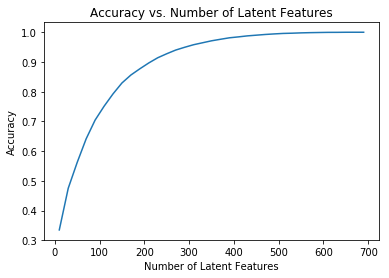

In [40]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [41]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    # Training and testing user_item sets
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # extract user_ids and article_ids in testing set
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [42]:
# Replace the values in the dictionary below

a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # len(np.intersect1d(user_item_train.index, user_item_test.index)) 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # len(user_item_test) - 20 
    'How many articles can we make predictions for in the test set?': b, # len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d # len(df_test['article_id'].unique()) - 574
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [43]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below
s_train.shape, u_train.shape, vt_train.shape

((714,), (4487, 4487), (714, 714))

Since the model trained with the training set can not be used to predict all users in the testing set, we need to do some filtering work before exploring how well our model is.

In [44]:
# First, get user_ids and article_ids from training set
train_idx = user_item_train.index
train_arts = user_item_train.columns

# Then, get user_ids and article_ids for those who are in both training and testing sets
test_idx_subset = np.intersect1d(test_idx, train_idx)
test_arts_subset = np.intersect1d(test_arts, train_arts)

# Obtain new training set and testing set according to test_idx_subset and test_arts_subset
user_item_train_subset = user_item_train.loc[test_idx_subset, test_arts_subset]
user_item_test_subset = user_item_test.loc[test_idx_subset, test_arts_subset]

# Get the indexes of the user_ids and article_ids, for the use of extrating sub-matrix from u_train and vt_train
train_index = np.where(np.in1d(train_idx, test_idx_subset))[0]
train_article = np.where(np.in1d(train_arts, test_arts_subset))[0]

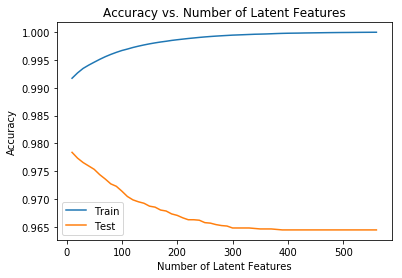

In [45]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

num_latent_feats = np.arange(10,570,10)
train_errs, test_errs = [], []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_test_k, u_test_k, vt_test_k = s_train_k, u_train_k[train_index,:], vt_train_k[:,train_article]
    
    # take dot product
    user_item_train_subset_est = np.around(np.dot(np.dot(u_train_k, s_train_k), vt_train_k)) 
    user_item_test_subset_est = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k)) 
    
    # compute error for each prediction to actual value
    diffs_test = np.subtract(user_item_test_subset, user_item_test_subset_est)
    diffs_train = np.subtract(user_item_train, user_item_train_subset_est)
    
    # total errors and keep track of them
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    err_train = np.sum(np.sum(np.abs(diffs_train)))

    test_errs.append(err_test)
    train_errs.append(err_train)


n_interactions_test = user_item_test_subset.shape[0]*user_item_test_subset.shape[1]
n_interactions_train = user_item_train.shape[0]*user_item_train.shape[1]

plt.figure()
plt.plot(num_latent_feats, 1 - np.array(train_errs)/n_interactions_train, label='Train')
plt.plot(num_latent_feats, 1 - np.array(test_errs)/n_interactions_test, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

From the figure above we could see that the accuracy of the model can be close to 0.980 when we limit the number of latent features to 10. While the number of latent features increase, the training accuracy increase to near 100%, yet the testing accuracy decrease. This can be possibly due to over fitting issue caused by introducing too many latent features into the training process. Over fitting issue means that the model captures both variance and noice in the training dataset, which may cause inappropriate modeling and incorrect prediction for testing dataset.

To determine a best number of latent features for the model, we may perform Cross Validation, to train the model with different subsets of the training datasets amd see the outcomes. 

Meanwhile, we could notice that the high prediction accuracy actually is not a appropriate metric for this problem, since the training and testing dataset is severely imbalanced. In other words, our datasets contain much more zeros than ones, thus some other metrics such as precision or recall may be more appropriate. 

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [47]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM_.ipynb'])

0